In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform


class TSNE:
    def __init__(self, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=None):
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state

    def fit_transform(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        N = X.shape[0]
        D = squareform(pdist(X, metric='euclidean'))

        P = self.__compute_affinities(D, self.perplexity)
        P = (P + P.T) / (2.0 * N)

        Y = np.random.normal(0.0, 1e-4, (N, 2))
        Y_prev = np.zeros((N, 2))

        alpha = 0.5
        eta = self.learning_rate

        for t in range(1, self.n_iter + 1):
            Q = self.__compute_low_dimensional_affinities(Y)
            grad = 4.0 * np.dot(P - Q, Y) * (1 + np.linalg.norm(Y))**(-1)

            if t > 1:
                Y_new = Y + eta * grad + alpha * (Y - Y_prev)
            else:
                Y_new = Y + eta * grad

            Y_prev = Y
            Y = Y_new

        return Y

    def __compute_affinities(self, distances, perplexity):
        beta = 1.0 / perplexity
        affinities = np.zeros_like(distances)

        for i in range(distances.shape[0]):
            dist_i = distances[i]
            affinities[i, :] = np.exp(-dist_i * beta)

        sum_aff = np.sum(affinities, axis=1)
        affinities /= sum_aff[:, np.newaxis]
        affinities[np.isnan(affinities)] = 0.0

        return affinities

    def __compute_low_dimensional_affinities(self, Y):
        distances = squareform(pdist(Y, metric='sqeuclidean'))
        inv_distances = 1.0 / (1.0 + distances)
        np.fill_diagonal(inv_distances, 0.0)
        sum_inv_distances = np.sum(inv_distances)
        Q = inv_distances / sum_inv_distances
        Q[np.isnan(Q)] = 0.0

        return Q


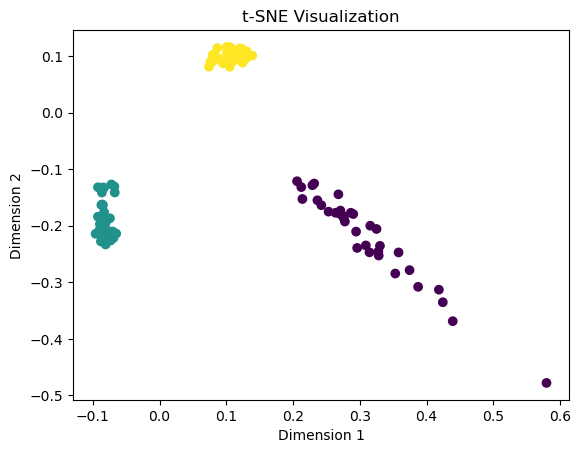

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=100, n_features=4, centers=3, random_state=42)
# print(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(perplexity=30.0, learning_rate=10.0, n_iter=1000, random_state=42)

Y = tsne.fit_transform(X_scaled)
# print(Y)

plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='viridis')
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()